## SGSC Lava Inference - Loihi - fixed point

In [1]:
%env CUDA_PATH=/usr/local/cuda

env: CUDA_PATH=/usr/local/cuda


In [2]:
import numpy as np
from lava.proc.lif.process import LIFReset
from lava.proc.lif.process import LIF
from lava.proc.io.source import RingBuffer
from lava.proc.dense.process import Dense
from lava.proc.monitor.process import Monitor
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi1SimCfg
from lava.magma.core.run_configs import Loihi2HwCfg
from matplotlib import pyplot as plt
from tqdm import tqdm
from lava.magma.core.process.process import LogConfig
import logging
from lava.utils.system import Loihi2
import os
from lava.proc.embedded_io.spike import PyToNxAdapter
from lava.proc.embedded_io.state import Read as StateReader
from lava.proc.io.sink import RingBuffer as SpikeOut
from lava.proc.io.sink import PyReceiveModelFixed
from lava.utils.loihi2_state_probes import StateProbe

import opendatasets as od
from SGSC_dataset_loader_padded_spikes import SGSC_Loader

def rescale_factor(w, bits):
    rng = float(2**(bits-1))
    mx = max(np.percentile(w,99), np.percentile(-w,99))
    fac = (rng-1)/mx
    mn = -(rng-2)/fac
    return (fac, mn, mx)

log_config = LogConfig("lava_SGSC.log")
log_config.level_console= logging.WARNING

params = {}
params["DT_MS"] = 1.0
params["TAU_MEM"] = 20.0
params["TAU_SYN"] = 2.0
params["num_samples"] = 10 #int(11005 / 8)
params["sample_id"] = 0     #sample used for graph generation (starting at 0, < num_samples)

params["NUM_INPUT"] = 80
params["NUM_HIDDEN"] = 512
params["NUM_OUTPUT"] = 35

params["timesteps"] = 2048

# toggle to record spikes, useful for debugging, but memory intensive
params["record_network_ih_activity"] =  True

os.environ["PATH"] += ":/nfs/ncl/bin:"
os.environ["PARTITION"] = "oheogulch_2h" # _2h (if 2 hours are needed)
os.environ['SLURM'] = '1'
os.environ['LOIHI_GEN'] = 'N3C1'

loihi2_is_available = Loihi2.is_loihi2_available

if loihi2_is_available:
    print(f'Running on {Loihi2.partition}')
    from lava.utils import loihi2_profiler
else:
    RuntimeError("Loihi2 compiler is not available in this system. "
                 "This tutorial cannot proceed further.")

do_plots= True
weight_bits= 8

# Kaggle dataset directory
dataset = 'https://www.kaggle.com/datasets/thomasshoesmith/spiking-google-speech-commands/data'

# Using opendatasets to download SGSC dataset
od.download(dataset)

x_train, y_train, x_test, y_test, x_validation, y_validation = SGSC_Loader(dir = os.getcwd() + "/spiking-google-speech-commands/",
                                                                           num_samples=params["num_samples"],
                                                                           shuffle = False,
                                                                           number_of_timesteps = params["timesteps"])

the_x = x_test
the_y = y_test

print(the_x[0].shape)

sample_image_start = the_x.shape[2] * params["sample_id"]
sample_image_end = (the_x.shape[2] * params["sample_id"]) + the_x.shape[2]

weight_bits= 8

# transform some parmeters
tau_mem_fac = 1.0-np.exp(-params["DT_MS"]/params["TAU_MEM"])
tau_mem_fac_int = int(np.round(tau_mem_fac*(2**12)))
tau_syn_fac = 1.0-np.exp(-params["DT_MS"]/params["TAU_SYN"])
tau_syn_fac_int = int(np.round(tau_syn_fac*(2**12)))

# load connections
w_i2h = np.load("SGSC_pretrained_weights/SGSC_Pop0_Pop1-g.npy")
w_i2h = w_i2h.reshape((params["NUM_INPUT"],
                       params["NUM_HIDDEN"])).T
w_i2h *= tau_mem_fac

w_h2h = np.load("SGSC_pretrained_weights/SGSC_Pop1_Pop1-g.npy")
w_h2h = w_h2h.reshape((params["NUM_HIDDEN"],
                       params["NUM_HIDDEN"])).T
w_h2h *= tau_mem_fac

w_h2o = np.load("SGSC_pretrained_weights/SGSC_Pop1_Pop2-g.npy")
w_h2o = w_h2o.reshape((params["NUM_HIDDEN"],
                       params["NUM_OUTPUT"])).T
w_h2o *= tau_mem_fac

# weight scaling
w = np.hstack([w_i2h,w_h2h])
w_2h_fac, mn, mx = rescale_factor(w,weight_bits)
w_i2h[w_i2h > mx] = mx
w_i2h[w_i2h < mn] = mn
w_i2h_int = np.round(w_i2h*w_2h_fac).astype(np.int8)
print(f"i2h: mn == {np.amin(w_i2h_int)}, mx == {np.amax(w_i2h_int)}")

w_h2h[w_h2h > mx] = mx
w_h2h[w_h2h < mn] = mn
w_h2h_int = np.round(w_h2h*w_2h_fac).astype(np.int8)
print(f"h2h: mn == {np.amin(w_h2h_int)}, mx == {np.amax(w_h2h_int)}")

w_2o_fac, mn, mx = rescale_factor(w_h2o,weight_bits)
w_2o_fac /= 2.0
mn *= 2.0
mx *= 2.0
w_h2o[w_h2o > mx] = mx
w_h2o[w_h2o < mn] = mn
w_h2o_int = np.round(w_h2o*w_2o_fac).astype(np.int8)
print(f"h2o: mn == {np.amin(w_h2o_int)}, mx == {np.amax(w_h2o_int)}")

vth_hid = w_2h_fac
vth_hid_int = int(np.round(vth_hid))

the_x= np.hstack(the_x)
print(the_x.shape)

# Create processes
input = RingBuffer(data=the_x)

py2nx_inp = PyToNxAdapter(shape=(the_x.shape[0],))

hidden = LIF(shape=(params["NUM_HIDDEN"], ),                         # Number and topological layout of units in the process
                  vth=vth_hid_int,                             # Membrane threshold
                  dv=tau_mem_fac_int,                              # Inverse membrane time-constant
                  du=tau_syn_fac_int,                              # Inverse synaptic time-constant
                  bias_mant=0,           # Bias added to the membrane voltage in every timestep
                  name="hidden",
                  #reset_interval=params["timesteps"],
                  log_config=log_config)

output = LIF(shape=(params["NUM_OUTPUT"], ),                         # Number and topological layout of units in the process
                  vth=2**15,                             # Membrane threshold
                  dv=tau_mem_fac_int,                              # Inverse membrane time-constant
                  du=tau_syn_fac_int,                              # Inverse synaptic time-constant
                  bias_mant=0,           # Bias added to the membrane voltage in every timestep
                  name="output",
                  #reset_interval=params["timesteps"],
                  log_config=log_config)

in_to_hid = Dense(weights= w_i2h_int,     # Initial value of the weights, chosen randomly
                  name='in_to_hid')

hid_to_hid = Dense(weights=w_h2h_int,
                   name='hid_to_hid')

hid_to_out = Dense(weights=w_h2o_int,
                   name= 'hid_to_out')

input.s_out.connect(py2nx_inp.inp)
py2nx_inp.out.connect(in_to_hid.s_in)
in_to_hid.a_out.connect(hidden.a_in)
hidden.s_out.connect(hid_to_hid.s_in)
hidden.s_out.connect(hid_to_out.s_in)
hid_to_hid.a_out.connect(hidden.a_in)
hid_to_out.a_out.connect(output.a_in)

Running on oheogulch_2h
Skipping, found downloaded files in "./spiking-google-speech-commands" (use force=True to force download)
loading training


100%|██████████| 10/10 [00:00<00:00, 9957.99it/s]


loading testing


100%|██████████| 10/10 [00:00<00:00, 10371.67it/s]


loading validation


100%|██████████| 10/10 [00:00<00:00, 6178.09it/s]

(80, 2048)
i2h: mn == -126, mx == 127
h2h: mn == -126, mx == 127
h2o: mn == -126, mx == 127
(80, 20480)


In [3]:
# probe recording
probe_v = StateProbe(output.v)

In [4]:
# monitor outputs
num_steps = int(params["timesteps"]/params["DT_MS"])
assert(num_steps == 2048)

# run something
run_condition = RunSteps(num_steps=num_steps)

run_cfg = Loihi2HwCfg(callback_fxs=[probe_v])
output._log_config.level = logging.INFO

In [5]:
for i in tqdm(range(params["num_samples"])):
    output.run(condition=run_condition, run_cfg=run_cfg)

    # reset the voltage after each trial
    hidden.v.set(np.zeros((params["NUM_HIDDEN"],), dtype = np.int32))
    hidden.u.set(np.zeros((params["NUM_HIDDEN"],), dtype = np.int32))
    output.v.set(np.zeros((params["NUM_OUTPUT"],), dtype = np.int32))
    output.u.set(np.zeros((params["NUM_OUTPUT"],), dtype = np.int32))

  0%|          | 0/10 [00:00<?, ?it/s]

Partitioning converged after iteration=4
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   3.20%|  12.50%|   0.85%|  38.40%|   0.22%|   0.00%|  33.63%|       1|
|   3.70%|  12.50%|   1.00%|  48.10%|   0.26%|   0.00%|  41.86%|      13|
|-----------------------------------------------------------------------|
| Total                                                        |      14|
-------------------------------------------------------------------------


/homes/ts468/lava_env/lib/python3.8/site-packages/nxcore/arch/n3b/n3board.py:54: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.185:37543
INFO:DRV:      Host server up..............Done 1.22s
INFO:DRV:      Mapping chipIds.............Done 0.02ms
INFO:DRV:      Mapping coreIds.............Done 0.14ms
INFO:DRV:      Partitioning neuron groups..Done 3.23ms
INFO:DRV:      Mapping axons...............Done 0.03s
INFO:DRV:      Configuring Spike Block.....Done 0.01ms
INFO:DRV:      Writes SpikeIO Config to FileDone 0.01ms
INFO:DRV:      Initializes Python MQ.......Done 0.00ms
INFO:DRV:      Partitioning MPDS...........Done 3.50ms
INFO:DRV:      Creating Embedded Snips and ChannelsDone 5.95ms
INFO:DRV:      Compiling Embedded snips....Done 0.67s
INFO:DRV:      Compiling Host snips........Done 0.18ms
INFO:DRV:      Compiling Register Probes...Done 2.58ms
INFO:DRV:      Compiling Spike Probes......Done 0.03ms
INFO:HST:  Args chip=0 cpu=0 /homes/ts468/lava_env/lib/python3.8/site-packages/nxcore/arch/base/pre_execution/../../../../temp/ed39b086

 10%|█         | 1/10 [01:53<17:05, 113.96s/it]

INFO:DRV:      Transferring probes.........Done 0.02ms
INFO:DRV:      Configuring registers.......Done 0.00ms
INFO:DRV:      Transferring spikes.........Done 0.00ms
INFO:DRV:      Executing...................Done 80.92s
INFO:DRV:      Processing timeseries.......Done 0.67s
INFO:DRV:  Executor: 2048 timesteps........Done 81.80s


 20%|██        | 2/10 [03:17<12:49, 96.19s/it] 

INFO:DRV:      Transferring probes.........Done 0.04ms
INFO:DRV:      Configuring registers.......Done 0.00ms
INFO:DRV:      Transferring spikes.........Done 0.00ms
INFO:DRV:      Executing...................Done 81.86s
INFO:DRV:      Processing timeseries.......Done 0.96s
INFO:DRV:  Executor: 2048 timesteps........Done 83.09s


 30%|███       | 3/10 [04:42<10:36, 90.92s/it]

INFO:DRV:      Transferring probes.........Done 0.02ms
INFO:DRV:      Configuring registers.......Done 0.00ms
INFO:DRV:      Transferring spikes.........Done 0.00ms
INFO:DRV:      Executing...................Done 83.83s
INFO:DRV:      Processing timeseries.......Done 0.85s
INFO:DRV:  Executor: 2048 timesteps........Done 84.77s


 40%|████      | 4/10 [06:08<08:54, 89.08s/it]

INFO:DRV:      Transferring probes.........Done 0.07ms
INFO:DRV:      Configuring registers.......Done 0.01ms
INFO:DRV:      Transferring spikes.........Done 0.00ms
INFO:DRV:      Executing...................Done 77.24s
INFO:DRV:      Processing timeseries.......Done 1.28s
INFO:DRV:  Executor: 2048 timesteps........Done 78.73s


 50%|█████     | 5/10 [07:28<07:09, 85.93s/it]

INFO:DRV:      Transferring probes.........Done 0.02ms
INFO:DRV:      Configuring registers.......Done 0.00ms
INFO:DRV:      Transferring spikes.........Done 0.00ms
INFO:DRV:      Executing...................Done 82.02s
INFO:DRV:      Processing timeseries.......Done 1.25s
INFO:DRV:  Executor: 2048 timesteps........Done 83.46s


 60%|██████    | 6/10 [08:54<05:43, 85.82s/it]

INFO:DRV:      Transferring probes.........Done 0.07ms
INFO:DRV:      Configuring registers.......Done 0.01ms
INFO:DRV:      Transferring spikes.........Done 0.00ms
INFO:DRV:      Executing...................Done 82.67s
INFO:DRV:      Processing timeseries.......Done 1.41s
INFO:DRV:  Executor: 2048 timesteps........Done 84.35s


 70%|███████   | 7/10 [10:20<04:17, 85.86s/it]

INFO:DRV:      Transferring probes.........Done 0.08ms
INFO:DRV:      Configuring registers.......Done 0.01ms
INFO:DRV:      Transferring spikes.........Done 0.00ms
INFO:DRV:      Executing...................Done 74.89s
INFO:DRV:      Processing timeseries.......Done 1.36s
INFO:DRV:  Executor: 2048 timesteps........Done 76.45s


 80%|████████  | 8/10 [11:38<02:46, 83.36s/it]

INFO:DRV:      Transferring probes.........Done 0.05ms
INFO:DRV:      Configuring registers.......Done 0.01ms
INFO:DRV:      Transferring spikes.........Done 0.00ms
INFO:DRV:      Executing...................Done 78.64s
INFO:DRV:      Processing timeseries.......Done 0.96s
INFO:DRV:  Executor: 2048 timesteps........Done 79.78s


 90%|█████████ | 9/10 [12:59<01:22, 82.71s/it]

INFO:DRV:      Transferring probes.........Done 0.05ms
INFO:DRV:      Configuring registers.......Done 0.01ms
INFO:DRV:      Transferring spikes.........Done 0.00ms
INFO:DRV:      Executing...................Done 75.05s
INFO:DRV:      Processing timeseries.......Done 0.91s
INFO:DRV:  Executor: 2048 timesteps........Done 76.14s


100%|██████████| 10/10 [14:17<00:00, 85.76s/it]


In [6]:
output.stop()
output_v = probe_v.time_series.reshape(35,num_steps*params["num_samples"]).T


INFO:HST:  Execution has not started yet or has finished.
INFO:HST:  Stopping Execution : at 20480
INFO:HST:  chip=0 cpu=1 halted, status=0x0
INFO:HST:  chip=0 cpu=0 halted, status=0x0


In [7]:
good = 0
for i in range(params["num_samples"]):
    out_v = output_v[i*num_steps:(i+1)*num_steps,:]
    #hid_v = hidden_v[i*num_steps:(i+1)*num_steps,:]
    sum_v = np.sum(out_v,axis=0)
    pred = np.argmax(sum_v)
    print(f"prediction {pred} vs ground truth {the_y[i]}")
    if pred == the_y[i]:
        good += 1

print("test accuracy: ", good/params["num_samples"]*100)

prediction 5 vs ground truth 1
prediction 16 vs ground truth 18
prediction 17 vs ground truth 30
prediction 16 vs ground truth 23
prediction 16 vs ground truth 23
prediction 19 vs ground truth 22
prediction 16 vs ground truth 6
prediction 16 vs ground truth 31
prediction 27 vs ground truth 18
prediction 16 vs ground truth 6
test accuracy:  0.0


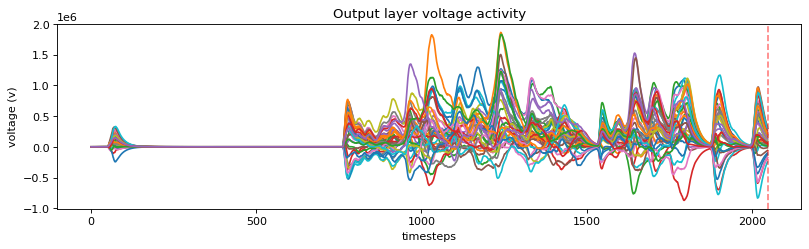

In [8]:
plt.figure(figsize=(12, 3), dpi=80)
plt.plot(out_v)
plt.title("Output layer voltage activity")
plt.ylabel("voltage (v)")
plt.xlabel("timesteps")
"""
plt.axvspan(256 * 2 + 40, 256 * 2 - 40, color='yellow', alpha=0.5)
plt.axvline(256 * 2, color = "red", alpha=0.5, linestyle = "dashed", label = f"timestep {256 * 2}")

plt.axvspan(256 * 3 + 40, 256 * 3 - 40, color='yellow', alpha=0.5)
plt.axvline(256 * 3, color = "red", alpha=0.5, linestyle = "dashed", label = f"timestep {256 * 3}")
"""
#plt.axvspan(256 * 4 + 40, 256 * 4 - 40, color='yellow', alpha=0.5)
#plt.axvline(256 * 4, color = "red", alpha=0.5, linestyle = "dashed", label = f"timestep {256 * 4}")
"""
plt.axvspan(256 * 5 + 40, 256 * 5 - 40, color='yellow', alpha=0.5)
plt.axvline(256 * 5, color = "red", alpha=0.5, linestyle = "dashed", label = f"timestep {256 * 5}")

plt.axvspan(256 * 6 + 40, 256 * 6 - 40, color='yellow', alpha=0.5)
plt.axvline(256 * 6, color = "red", alpha=0.5, linestyle = "dashed", label = f"timestep {256 * 6}")

"""
#plt.xlim(500, 600)
#plt.figure()
#plt.plot(hid_v)
plt.axvline(2048, color = "red", alpha=0.5, linestyle = "dashed", label = f"timestep {256 * 4}")

plt.show()